In [1]:
# IMPORTS
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sc
from scipy import linalg, optimize, constants, interpolate, special, stats
import math as ma
from math import exp, pow, sqrt, log
import seaborn as sns 
import statsmodels.api as sm
import statsmodels.stats.api as sms
import keras
import random
from keras.utils import plot_model, to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Reshape
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten, Input, UpSampling1D
from keras.optimizers import SGD
import sklearn as sl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from prettytable import PrettyTable
from keras import backend as K
from sklearn.utils import shuffle
from sklearn.decomposition import PCA


%matplotlib inline

Using TensorFlow backend.


# Autoencoder mit komprimiertem Input (Ausgabe Klasse)

In [2]:
# csv einlesen
Vein = pd.read_csv('datensatz/vein.csv')
# dataframe draus machen
df = pd.DataFrame(Vein)

df = df.iloc[1:, 1:]

df = shuffle(df)

inputs = df.iloc[:, 1:].values
targets = df.iloc[:, 0].values


#Standardscaler über inputs laufen lassen 
scaler = StandardScaler()
scaler.fit(inputs)
# Apply transform to Inputs
scaled_inputs = scaler.transform(inputs)

# Make an instance of the Model
pca = PCA(n_components=20) # ODER: pca = PCA(n_components=20)
pca.fit(scaled_inputs)

inputs = pca.transform(scaled_inputs)

# splitten in Trainings Daten und Prediction Daten:

# TRAINING
training_inputs = inputs[0:10]
training_targets = targets[0:10]

training_inputs = training_inputs.reshape(training_inputs.shape[0],20,1).astype( 'float32' )

# PREDICTION
pred_inputs = inputs[10:]
pred_targets = targets[10:]

pred_inputs = pred_inputs.reshape(pred_inputs.shape[0],20,1).astype( 'float32' )

#Trainingsdaten in test und training splitten (7:3)
inputs_train, inputs_test, targets_train, targets_test = train_test_split(training_inputs, training_targets, test_size = 0.3)

print('\n-----------------')
#TARGETS
targets_train_categorial = to_categorical(targets_train)
targets_test_categorial = to_categorical(targets_test)

#(Anzahl Datenpunkte, Höhe, Breite, Kanäle)  
print('Training data shape : ', inputs_train.shape, targets_train_categorial.shape)
print('Testing data shape : ', inputs_test.shape, targets_test_categorial.shape)


x = PrettyTable()
x.field_names = ["target", "!has_DM2", "has_DM2"]

i = 0
for target in targets_train_categorial:
    hasNotDM2, hasDM2 = target
    x.add_row([targets_train[i],hasNotDM2, hasDM2])
    i+=1
print(x)


-----------------
Training data shape :  (7, 20, 1) (7, 2)
Testing data shape :  (3, 20, 1) (3, 1)
+--------+----------+---------+
| target | !has_DM2 | has_DM2 |
+--------+----------+---------+
|  1.0   |   0.0    |   1.0   |
|  1.0   |   0.0    |   1.0   |
|  0.0   |   1.0    |   0.0   |
|  0.0   |   1.0    |   0.0   |
|  1.0   |   0.0    |   1.0   |
|  0.0   |   1.0    |   0.0   |
|  1.0   |   0.0    |   1.0   |
+--------+----------+---------+


In [3]:
#Funktion für Plot Loss
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [8]:
# ENCODER
print('-------ENCODING--------')
input_sig = Input(batch_shape=(None,20,1))
x = Conv1D(16,2, activation='relu', padding='valid')(input_sig)
print('1. Schicht : ', x.shape)
x1 = MaxPooling1D(2)(x)
print('Maxpooling : ', x1.shape)
x2 = Conv1D(32,2, activation='relu', padding='valid')(x1)
print('2. Schicht : ', x1.shape)
x3 = MaxPooling1D(2)(x2)
print('Maxpooling : ', x3.shape)
flat = Flatten()(x3)
encoded = Dense(32,activation = 'relu')(flat)
print("Encoder Shape {}".format(K.int_shape(encoded)))
# DECODER 
print('--------DECODING-------')
x2_ = Conv1D(32, 2, activation='relu', padding='valid')(x3)
print('3. Schicht : ', x2_.shape)
x1_ = UpSampling1D(3)(x2_)
print('Upsampling : ', x1_.shape)
x_ = Conv1D(32, 2, activation='relu', padding='valid')(x1_)
print('4. Schicht : ', x_.shape)
upsamp = UpSampling1D(3)(x_)
print('Upsampling : ', upsamp.shape)

flat = Flatten()(upsamp)
decoded = Dense(2,activation = 'softmax')(flat)
decoded = Reshape((2,1))(decoded)
 
print("Decoder Shape {}".format(K.int_shape(decoded)))
 
autoencoder = Model(input_sig, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
autoencoder.summary()

-------ENCODING--------
1. Schicht :  (None, 19, 16)
Maxpooling :  (None, 9, 16)
2. Schicht :  (None, 9, 16)
Maxpooling :  (None, 4, 32)
Encoder Shape (None, 32)
--------DECODING-------
3. Schicht :  (None, 3, 32)
Upsampling :  (None, 9, 32)
4. Schicht :  (None, 8, 32)
Upsampling :  (None, 24, 32)
Decoder Shape (None, 2, 1)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 20, 1)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 19, 16)            48        
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 9, 16)             0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 8, 32)             1056      
_______________________________________________________________

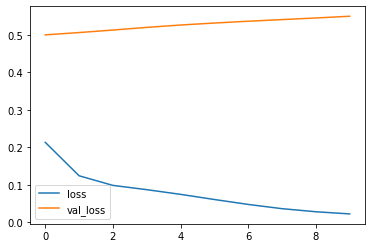

3/3 [==============================] - 0s 409us/step
Accuracy: 33.33


In [16]:
targets_train_categorial = targets_train_categorial.reshape(targets_train_categorial.shape[0],2,1).astype( 'float32' )
targets_test_categorial = targets_test_categorial.reshape(targets_test_categorial.shape[0],2,1).astype( 'float32' )
autoencoder_train = autoencoder.fit(inputs_train, targets_train_categorial, 
                                    batch_size=7,
                                    epochs=10,
                                    verbose=1,
                                    validation_data=(inputs_test, targets_test_categorial),
                                    callbacks=[plot_losses])

nochUnbekannterWert, score = autoencoder.evaluate(inputs_test, targets_test_categorial, batch_size=targets_test_categorial.shape[0])
print('Accuracy: %.2f' % (score*100))

In [18]:
#Prediction
pred = autoencoder.predict(pred_inputs)

In [21]:
y = PrettyTable()
y.field_names = ["Testmenge", "Rekonstruktion (!has_DM2)", "Rekonstruktion (has_DM2)", "check"]

i = 0
for i in range(8):
    soll = pred_targets[i]
    ist = pred[i][0]
    ist2 = pred[i][1]
    check = '\u2716'
    if soll == 0.0 and ist > 0.5:
        check = u'\u2714'
    elif soll == 1.0 and ist2 > 0.5:
        check = u'\u2714'
    
    y.add_row([soll, ist, ist2, check])
    i+=1
print(y)

+-----------+---------------------------+--------------------------+-------+
| Testmenge | Rekonstruktion (!has_DM2) | Rekonstruktion (has_DM2) | check |
+-----------+---------------------------+--------------------------+-------+
|    1.0    |        [0.8088248]        |       [0.19117527]       |   ✖   |
|    0.0    |        [0.10684545]       |       [0.8931546]        |   ✖   |
|    1.0    |        [0.6099252]        |       [0.3900748]        |   ✖   |
|    1.0    |        [0.37858436]       |       [0.6214157]        |   ✔   |
|    1.0    |        [0.33402005]       |       [0.6659799]        |   ✔   |
|    1.0    |        [0.7101745]        |       [0.2898255]        |   ✖   |
|    1.0    |        [0.31395635]       |       [0.6860436]        |   ✔   |
|    0.0    |        [0.52548856]       |       [0.4745115]        |   ✔   |
+-----------+---------------------------+--------------------------+-------+
